<a href="https://colab.research.google.com/github/sultanbst123/Zindi_Africa-Gender-Based-Violence-Tweet-Classification/blob/main/Classification_tweet_kekerasan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Gender-Based Violence Tweet Classification Challenge

## Library & File

In [ ]:
!pip install transformers

     |████████████████████████████████| 3.1 MB 5.3 MB/s 
     |████████████████████████████████| 59 kB 6.5 MB/s 
     |████████████████████████████████| 895 kB 57.0 MB/s 
     |████████████████████████████████| 3.3 MB 48.4 MB/s 
     |████████████████████████████████| 596 kB 46.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
#basic library
import numpy as np
import pandas as pd
import re
 
#deep learning library
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Embedding, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers.schedules import PolynomialDecay

#visualization library
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
%matplotlib inline
 
#text preprocesing library
import nltk
from nltk import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, f1_score, mean_squared_log_error, log_loss, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [ ]:
# transformers library 

# distilbert
from transformers import DistilBertTokenizerFast #tokenizer mengunakan subword 
 
from transformers import TFDistilBertModel, DistilBertConfig #distilbert
from transformers import TFBertModel, BertConfig #bert

In [ ]:
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("punkt")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
train = pd.read_csv("/content/drive/MyDrive/NlP tweet kekerasan berbasis gender part 2/Train (1).csv") 
test = pd.read_csv("/content/drive/MyDrive/NlP tweet kekerasan berbasis gender part 2/Test (1).csv") 
sub = pd.read_csv("/content/drive/MyDrive/NlP tweet kekerasan berbasis gender part 2/SampleSubmission.csv")

In [ ]:
train.head()

,Tweet_ID,tweet,type
0,ID_0022DWKP,Had a dream i got raped last night. By a guy i...,sexual_violence
1,ID_00395QYM,he thought the word raped means sex and told m...,sexual_violence
2,ID_003EOSSF,She NOT TALKING TO ME I WAS RAPED BY 2 MEN 1 M...,sexual_violence
3,ID_004BBHOD,I was sexually abused for 3 years at age 4 to ...,sexual_violence
4,ID_004F7516,Chessy Prout can do better by telling the trut...,sexual_violence


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39650 entries, 0 to 39649
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Tweet_ID  39650 non-null  object
 1   tweet     39650 non-null  object
 2   type      39650 non-null  object
dtypes: object(3)
memory usage: 929.4+ KB


## EDA & Text Cleaning

### EDA

,type
sexual_violence,0.823405
Physical_violence,0.149962
emotional_violence,0.016419
economic_violence,0.005473
Harmful_Traditional_practice,0.004741


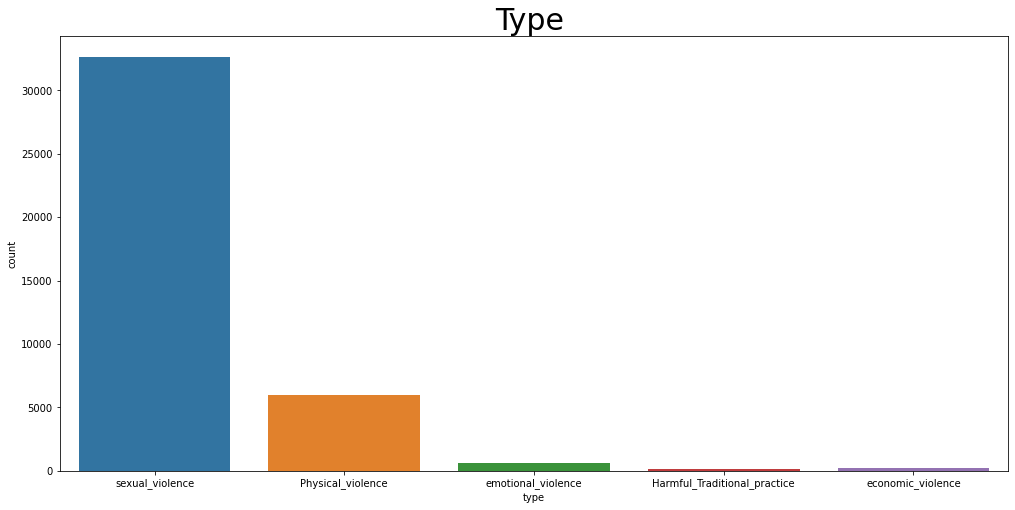

In [ ]:

#target 
plt.figure(figsize=(17, 8)) 
sns.countplot(train.type)
plt.title("Type ",fontsize=30) 

train.type.value_counts(normalize=True).to_frame()

In [ ]:
word_train = train["tweet"].str.len()
word_test = test["tweet"].str.len()

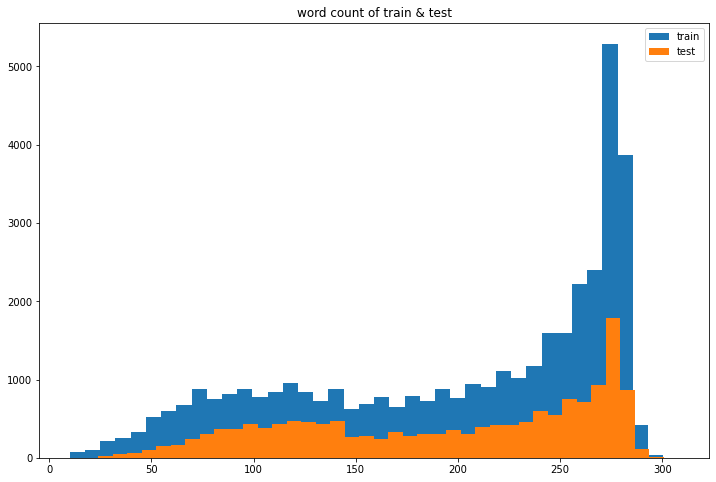

In [ ]:
plt.subplots(figsize=(12, 8))
plt.hist(word_train,bins=40,label="train")
plt.hist(word_test,bins=40,label="test")
plt.title("word count of train & test") 
plt.legend()

In [ ]:

Total_word_of_train = train.tweet.apply(lambda x: len(x.split())).sum()
Total_word_of_test = test.tweet.apply(lambda x: len(x.split())).sum()

In [ ]:
print(f"Total kata dari train: {Total_word_of_train}")
print(f"Total kata dari test: {Total_word_of_test}")

Total kata dari train: 1541826
Total kata dari test: 554761


In [ ]:
# check duplicate

train.duplicated().sum()

0

In [ ]:
# check null 
train.isnull().sum()

Tweet_ID    0
tweet       0
type        0
dtype: int64

In [ ]:

# filter berdasarkan type 

len_word_sexual = train.query("type == 'sexual_violence'").tweet.str.len() 
len_word_physical = train.query("type == 'Physical_violence'").tweet.str.len()
len_word_emotional = train.query("type == 'emotional_violence'").tweet.str.len()
len_word_economic = train.query("type == 'economic_violence'").tweet.str.len()
len_word_HT = train.query("type == 'Harmful_Traditional_practice'").tweet.str.len()

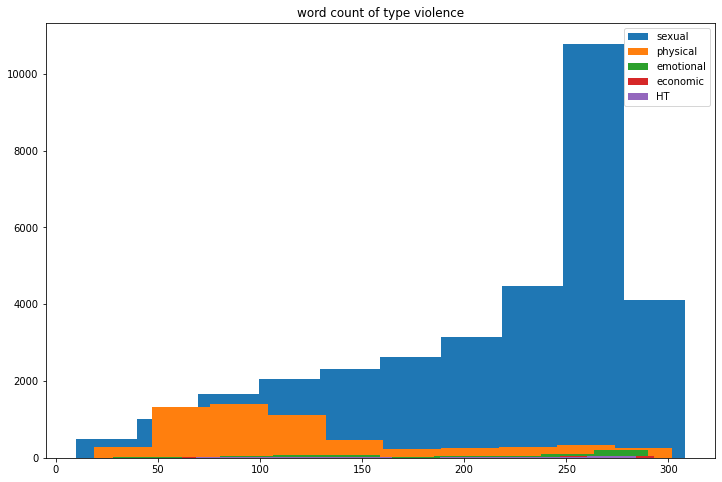

In [ ]:
plt.subplots(figsize=(12, 8))
plt.hist(len_word_sexual,label="sexual")
plt.hist(len_word_physical,label="physical")
plt.hist(len_word_emotional,label="emotional")
plt.hist(len_word_economic,label="economic")
plt.hist(len_word_HT,label="HT")

plt.title("word count of type violence") 
plt.legend()

In [ ]:
print(f"Total kata dari sexual_violence: {len_word_sexual.sum()}")
print(f"Total kata Physical_violence : {len_word_physical.sum()}")
print(f"Total kata dari emotional_violence: {len_word_emotional.sum()}")
print(f"Total kata economic_violence : {len_word_economic.sum()}")
print(f"Total kata dari Harmful_Traditional_practice: {len_word_HT.sum()}")

Total kata dari sexual_violence: 6964077
Total kata Physical_violence : 729430
Total kata dari emotional_violence: 131927
Total kata economic_violence : 44568
Total kata dari Harmful_Traditional_practice: 36052


### Cleaning

In [ ]:
#mengubah kata-kata singkat / contractions
def cont(tweet): 
    tweet = re.sub(r"he's", "he is", tweet)
    tweet = re.sub(r"there's", "there is", tweet)
    tweet = re.sub(r"We're", "we are", tweet)
    tweet = re.sub(r"That's", "that is", tweet)
    tweet = re.sub(r"won't", "will not", tweet)
    tweet = re.sub(r"they're", "they are", tweet)
    tweet = re.sub(r"Can't", "cannot", tweet)
    tweet = re.sub(r"wasn't", "was not", tweet)
    tweet = re.sub(r"don\x89Ûªt", "do not", tweet)
    tweet = re.sub(r"aren't", "are not", tweet)
    tweet = re.sub(r"isn't", "is not", tweet)
    tweet = re.sub(r"What's", "what is", tweet)
    tweet = re.sub(r"haven't", "have not", tweet)
    tweet = re.sub(r"hasn't", "has not", tweet)
    tweet = re.sub(r"There's", "there is", tweet)
    tweet = re.sub(r"He's", "he is", tweet)
    tweet = re.sub(r"It's", "it is", tweet)
    tweet = re.sub(r"You're", "you are", tweet)
    tweet = re.sub(r"I'M", "i am", tweet)
    tweet = re.sub(r"shouldn't", "should not", tweet)
    tweet = re.sub(r"wouldn't", "would not", tweet)
    tweet = re.sub(r"i'm", "i am", tweet)
    tweet = re.sub(r"I\x89Ûªm", "i am", tweet)
    tweet = re.sub(r"I'm", "i am", tweet)
    tweet = re.sub(r"Isn't", "is not", tweet)
    tweet = re.sub(r"Here's", "here is", tweet)
    tweet = re.sub(r"you've", "you have", tweet)
    tweet = re.sub(r"you\x89Ûªve", "you have", tweet)
    tweet = re.sub(r"we're", "we are", tweet)
    tweet = re.sub(r"what's", "what is", tweet)
    tweet = re.sub(r"couldn't", "could not", tweet)
    tweet = re.sub(r"we've", "we have", tweet)
    tweet = re.sub(r"it\x89Ûªs", "it is", tweet)
    tweet = re.sub(r"doesn\x89Ûªt", "does not", tweet)
    tweet = re.sub(r"It\x89Ûªs", "it is", tweet)
    tweet = re.sub(r"Here\x89Ûªs", "here is", tweet)
    tweet = re.sub(r"who's", "who is", tweet)
    tweet = re.sub(r"I\x89Ûªve", "i have", tweet)
    tweet = re.sub(r"y'all", "you all", tweet)
    tweet = re.sub(r"can\x89Ûªt", "cannot", tweet)
    tweet = re.sub(r"would've", "would have", tweet)
    tweet = re.sub(r"it'll", "it will", tweet)
    tweet = re.sub(r"we'll", "we will", tweet)
    tweet = re.sub(r"wouldn\x89Ûªt", "would not", tweet)
    tweet = re.sub(r"We've", "we have", tweet)
    tweet = re.sub(r"he'll", "he will", tweet)
    tweet = re.sub(r"Y'all", "you all", tweet)
    tweet = re.sub(r"Weren't", "were not", tweet)
    tweet = re.sub(r"Didn't", "did not", tweet)
    tweet = re.sub(r"they'll", "they will", tweet)
    tweet = re.sub(r"they'd", "they would", tweet)
    tweet = re.sub(r"DON'T", "DO NOT", tweet)
    tweet = re.sub(r"That\x89Ûªs", "that is", tweet)
    tweet = re.sub(r"they've", "they have", tweet)
    tweet = re.sub(r"i'd", "i would", tweet)
    tweet = re.sub(r"should've", "should have", tweet)
    tweet = re.sub(r"You\x89Ûªre", "you are", tweet)
    tweet = re.sub(r"where's", "where is", tweet)
    tweet = re.sub(r"Don\x89Ûªt", "do not", tweet)
    tweet = re.sub(r"we'd", "we would", tweet)
    tweet = re.sub(r"i'll", "i will", tweet)
    tweet = re.sub(r"weren't", "were not", tweet)
    tweet = re.sub(r"They're", "they are", tweet)
    tweet = re.sub(r"Can\x89Ûªt", "cannot", tweet)
    tweet = re.sub(r"you\x89Ûªll", "you will", tweet)
    tweet = re.sub(r"I\x89Ûªd", "i would", tweet)
    tweet = re.sub(r"let's", "let us", tweet)
    tweet = re.sub(r"it's", "it is", tweet)
    tweet = re.sub(r"can't", "cannot", tweet)
    tweet = re.sub(r"don't", "do not", tweet)
    tweet = re.sub(r"you're", "you are", tweet)
    tweet = re.sub(r"i've", "i have", tweet)
    tweet = re.sub(r"that's", "that is", tweet)
    tweet = re.sub(r"i'll", "i will", tweet)
    tweet = re.sub(r"doesn't", "does not", tweet)
    tweet = re.sub(r"i'd", "i would", tweet)
    tweet = re.sub(r"didn't", "did not", tweet)
    tweet = re.sub(r"ain't", "am not", tweet)
    tweet = re.sub(r"you'll", "you will", tweet)
    tweet = re.sub(r"I've", "i have", tweet)
    tweet = re.sub(r"Don't", "do not", tweet)
    tweet = re.sub(r"I'll", "i will", tweet)
    tweet = re.sub(r"I'd", "i would", tweet)
    tweet = re.sub(r"Let's", "let us", tweet)
    tweet = re.sub(r"you'd", "you would", tweet)
    tweet = re.sub(r"It's", "it is", tweet)
    tweet = re.sub(r"Ain't", "am not", tweet)
    tweet = re.sub(r"Haven't", "have not", tweet)
    tweet = re.sub(r"Could've", "could have", tweet)
    tweet = re.sub(r"amp", "&", tweet)
    tweet = re.sub(r"<br /><br />", " ", tweet)
    return tweet

In [ ]:

# hapus emoji 

def emoji(tweet): 
    emoji_pattern = re.compile("["        
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U0001F1F2-\U0001F1F4"  # Macau flag
        u"\U0001F1E6-\U0001F1FF"  # flags
        u"\U0001F600-\U0001F64F"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U0001F1F2"
        u"\U0001F1F4"
        u"\U0001F620"
        u"\u200d"
        u"\u2640-\u2642"
        "]+", flags=re.UNICODE)
    
    text =  emoji_pattern.sub(r"", tweet)
 
    return text

In [ ]:
#menghapus semua simbol, white space dan @user mention
def remove_punc(tweet): 
    tweet = re.sub(r"@[\w]*", " ",tweet)
    tweet = re.sub(r"[^a-zA-Z]"," ",tweet)
    tweet = re.sub(r"\s+"," ",tweet)
    
    return tweet

In [ ]:
#menghapus stopwords
def remove_stopwords(tweet):
    ts = word_tokenize(tweet) 
    ts_without_sw = [word for word in ts if not word in stopwords.words("english")]
    tweet = " ".join([str(elem) for elem in ts_without_sw])

    return tweet

In [ ]:
#lemmatizer
def lemma(tweet):
    ts = tweet.split() 
    wnl = WordNetLemmatizer()
    tweet = " ".join([wnl.lemmatize(words) for words in ts])

    return tweet

In [ ]:
#stemming mengunakan snowball
def stem(tweet):
    ts = tweet.split() 
    wnl = SnowballStemmer("english") 
    tweet = " ".join([wnl.stem(words) for words in ts])

    return tweet

In [ ]:
def clean(tweet):
    #text
    tweet = tweet.lower()
    tweet = cont(tweet)
    tweet = emoji(tweet) 
    #symbol number special character
    tweet = remove_punc(tweet) 
    #stopword and lemmatizer
    tweet = remove_stopwords(tweet)
    tweet = lemma(tweet)
    #tweet = stem(tweet)
    return tweet

In [ ]:
train["clean_tweet"] = train["tweet"].apply(clean)

In [ ]:
test["clean_tweet"] = test["tweet"].apply(clean)

In [ ]:

# setelah membersikan teks
print(f"Total kata dari train: {train.clean_tweet.apply(lambda x: len(x.split())).sum()}")
print(f"Total kata dari test: {test.clean_tweet.apply(lambda x: len(x.split())).sum()}")

Total kata dari train: 714562
Total kata dari test: 279376


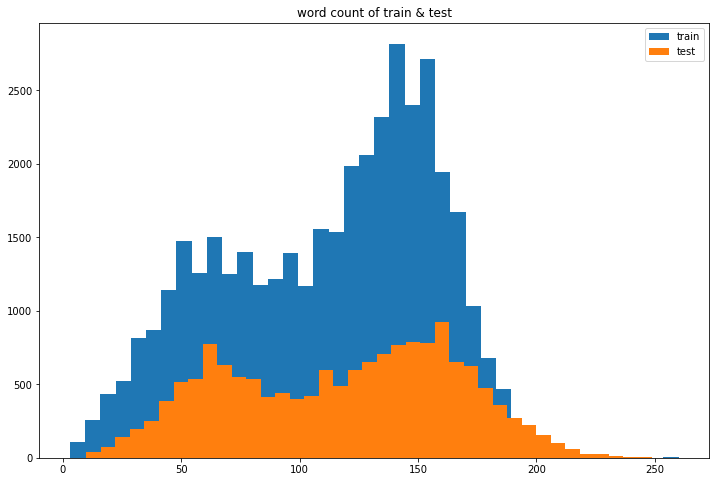

In [ ]:

# panjang kata setelah pembersihan 

plt.subplots(figsize=(12, 8))
plt.hist(train.clean_tweet.str.len(),bins=40,label="train")
plt.hist(test.clean_tweet.str.len(),bins=40,label="test")
plt.title("word count of train & test") 
plt.legend()

In [ ]:
train["clean_tweet"].sample(10)

8532     know without doubt life husband etc know witho...
14391    look original tweet stop goofy im going back f...
18023    gave chance chance wanted change sociopath exp...
31493                 someone might think husband beat lol
1400     beat somewhat weary husband activity whilst sl...
36584    dunno anymore told strangled n raped n told go...
32822    totally guilty raped metro trip mexico howard ...
36895    accepted point ex le pointing missed thousand ...
11707    hey get raped want keep baby several state rig...
1307     nobody raped people donald believe many people...
Name: clean_tweet, dtype: object

In [ ]:
def wordCloud_generator(data, title=None):
    wordcloud = WordCloud(width = 900, height = 700,
                          background_color ='black',
                          min_font_size = 10
                         ).generate(" ".join(data.values))
    # plot the WordCloud image                        
    plt.figure(figsize = (10, 10), facecolor = None) 
    plt.imshow(wordcloud, interpolation='bilinear') 
    plt.axis("off")
    plt.title(title,fontsize=17)
    plt.show()

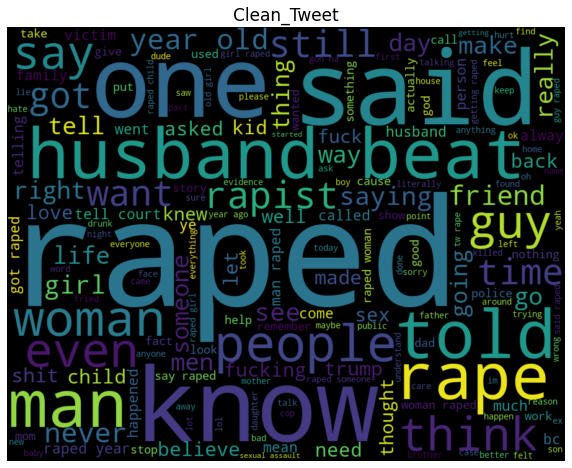

In [ ]:
wordCloud_generator(train["clean_tweet"], title="Clean_Tweet")

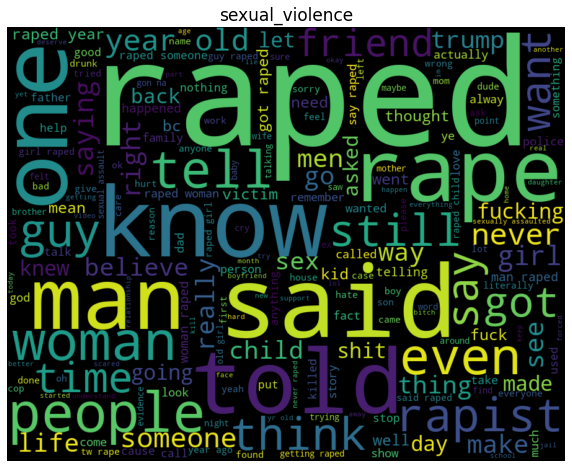

In [ ]:
wordCloud_generator(train["clean_tweet"][train.type == "sexual_violence"], title="sexual_violence")

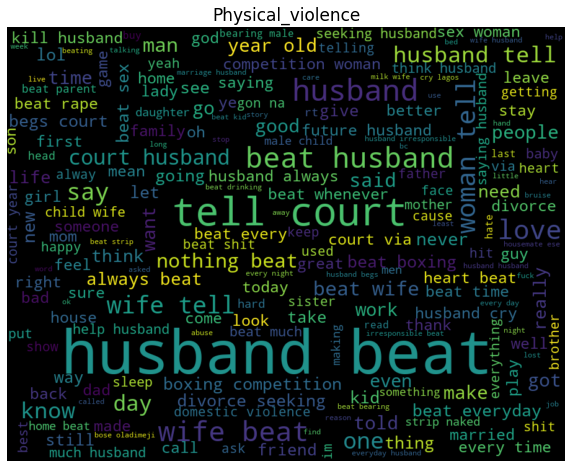

In [ ]:
wordCloud_generator(train["clean_tweet"][train.type == "Physical_violence"], title="Physical_violence")

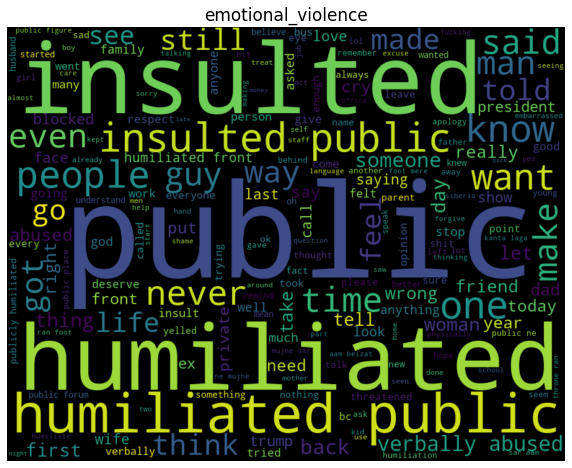

In [ ]:
 wordCloud_generator(train["clean_tweet"][train.type == "emotional_violence"], title="emotional_violence")

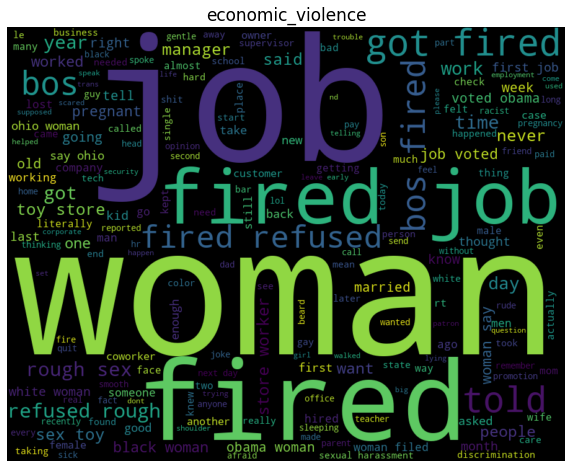

In [ ]:
 wordCloud_generator(train["clean_tweet"][train.type == "economic_violence"], title="economic_violence")

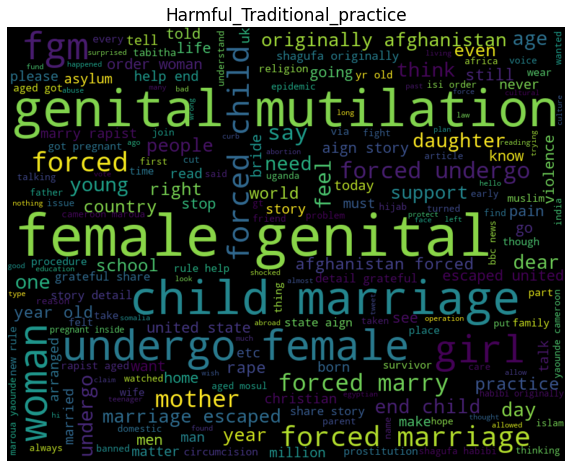

In [ ]:
 wordCloud_generator(train["clean_tweet"][train.type == "Harmful_Traditional_practice"], title="Harmful_Traditional_practice")

## Setting hardware GPU/TPU, for a distributed learning

In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print("Running on TPU ", tpu.cluster_spec().as_dict()["worker"])
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    print("Not connected to a TPU runtime. Using CPU/GPU strategy")
    strategy = tf.distribute.MirroredStrategy()

Running on TPU  ['10.100.117.90:8470']


INFO:absl:Entering into master device scope: /job:worker/replica:0/task:0/device:CPU:0


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.100.117.90:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.100.117.90:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [ ]:
print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 8


In [ ]:
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

LEARNING_RATE = 5e-5 * strategy.num_replicas_in_sync

AUTO = tf.data.experimental.AUTOTUNE

## Split & Tokenize text

### Split 90:10

In [ ]:
# ohe label mengunakan pd dummies

#label = pd.get_dummies(train.type)

# encode untuk mempertahankan nama label untuk submission
lc = LabelEncoder() 
label = lc.fit_transform(train.type)

In [ ]:

# lalu ohe 
to_categorical(label)

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]], dtype=float32)

In [ ]:
x = train.clean_tweet.values
y = to_categorical(label).astype("int32")
test_txt = test.clean_tweet.values

In [ ]:
# split 90:10 stratify 

train_txt,val_txt,train_label,val_label = train_test_split(x, y, test_size=0.1, stratify=y, random_state=42)

In [ ]:
train_txt.shape, val_txt.shape, train_label.shape, val_label.shape

((35685,), (3965,), (35685, 5), (3965, 5))

###Tokenize

In [ ]:

# tokenize type subword mengunakan distilbert fast, karena mempunyai kelebihan banyak 

tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
MAX_LENGTH = 128
# MAX_LENGTH = 512 <=== default

# buat function tokenize 

def tokenize(sentences, tokenizer,max_length = MAX_LENGTH):
    input_ids, input_masks= [],[]
    for sentence in sentences:
        inputs = tokenizer.encode_plus(sentence,truncation=True, add_special_tokens=True, max_length=MAX_LENGTH, pad_to_max_length=True, 
                                             return_attention_mask=True, return_token_type_ids=True)
        input_ids.append(inputs['input_ids'])
        input_masks.append(inputs['attention_mask'])
       
    return np.asarray(input_ids, dtype='int32'), np.asarray(input_masks,dtype='int32')

In [ ]:

# Encode train
X_train_ids, X_train_attention = tokenize(train_txt,tokenizer)

# Encode valid
X_valid_ids, X_valid_attention = tokenize(val_txt,tokenizer)

# Encode test
X_test_ids, X_test_attention = tokenize(test_txt,tokenizer)

In [ ]:
# ambil 10 sample untuk melihat apakah panjang nya sama 
[len(x) for x in X_train_ids[:10]]

[128, 128, 128, 128, 128, 128, 128, 128, 128, 128]

In [ ]:
train_dataset = (
    tf.data.Dataset.from_tensor_slices(((X_train_ids, X_train_attention), train_label))
    .shuffle(1000)
    .batch(BATCH_SIZE)
    .prefetch(AUTO) 
)

val_dataset = (
    tf.data.Dataset.from_tensor_slices(((X_valid_ids, X_valid_attention), val_label)) 
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.Dataset.from_tensor_slices(((X_test_ids, X_test_attention))) 
    .batch(BATCH_SIZE)
)

In [ ]:
train_dataset

<PrefetchDataset shapes: (((None, 128), (None, 128)), (None, 5)), types: ((tf.int32, tf.int32), tf.int32)>

In [ ]:
val_dataset

<PrefetchDataset shapes: (((None, 128), (None, 128)), (None, 5)), types: ((tf.int32, tf.int32), tf.int32)>

In [ ]:
test_dataset

<BatchDataset shapes: ((None, 128), (None, 128)), types: (tf.int32, tf.int32)>

## Fit

In [ ]:
EPOCHS = 10 
num_train_steps = len(train_txt) * EPOCHS

# buat learning_rate decay, learning rate akan berkurang secara linear 

lr_scheduler = PolynomialDecay(
    initial_learning_rate=LEARNING_RATE, end_learning_rate=0.0, decay_steps=num_train_steps
)

# buat cb early stopp
early_stop = EarlyStopping(monitor='val_loss',
                           patience=5, 
                           restore_best_weights=True)

In [ ]:
# gunakan algorithm Adam & clipnorm utk mengatasi exploding gradient
     
adam = Adam(learning_rate=lr_scheduler,clipnorm=1.0)

### distilbert

In [ ]:
#fine tuning distilbert  dari 0.1 ke 0.2

config = DistilBertConfig(dropout=0.2, attention_dropout=0.2)
config.output_hidden_states = False

transformer_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased', config = config)

Downloading:   0%|          | 0.00/347M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_layer_norm', 'vocab_transform', 'activation_13', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [ ]:

# cek distbert apakah berubah setelah di tuning 

transformer_model.config

DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "attention_dropout": 0.2,
  "dim": 768,
  "dropout": 0.2,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "transformers_version": "4.12.3",
  "vocab_size": 30522
}

In [ ]:

#tambahkan bi-lstm(lstm dua arah)  lalu ratakan jadi 1D mengunakan globalmaxpooling

def build_model(transformer, max_length=MAX_LENGTH):
  
    # input layers
    input_ids_in = tf.keras.layers.Input(shape=(MAX_LENGTH,), name='input_token', dtype='int32')
    input_masks_in = tf.keras.layers.Input(shape=(MAX_LENGTH,), name='masked_token', dtype='int32')

    embedding_layer = transformer(input_ids_in, attention_mask=input_masks_in)[0]
    #cls_token = embedding_layer[:,0,:]
                                  
    X = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(embedding_layer)
    X = tf.keras.layers.GlobalMaxPool1D()(X) # 
    X = tf.keras.layers.Dense(50, activation='relu')(X)
    X = tf.keras.layers.Dropout(0.1)(X)
    X = tf.keras.layers.Dense(5, activation='softmax')(X)
    model = tf.keras.Model(inputs=[input_ids_in, input_masks_in], outputs = X)    
    
    # freeze distilbert layers 
    for layer in model.layers[:3]:
        layer.trainable = False

    return model

In [ ]:
model = build_model(transformer_model)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_token (InputLayer)       [(None, 128)]        0           []                               
                                                                                                  
 masked_token (InputLayer)      [(None, 128)]        0           []                               
                                                                                                  
 tf_distil_bert_model (TFDistil  TFBaseModelOutput(l  66362880   ['input_token[0][0]',            
 BertModel)                     ast_hidden_state=(N               'masked_token[0][0]']           
                                one, 128, 768),                                                   
                                 hidden_states=None                                           

In [ ]:
# buat ulang model di TPU
 
with strategy.scope(): # <=== with TPU
     transformer_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased', config = config)

     model = build_model(transformer_model)
     
     model.compile(optimizer = adam, loss="categorical_crossentropy", metrics =["accuracy"])

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_layer_norm', 'vocab_transform', 'activation_13', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [ ]:

# latih dengan TPU 

history = model.fit(train_dataset, validation_data = val_dataset,
     callbacks=[early_stop],
     epochs=EPOCHS,
     verbose=True)

Epoch 1/10


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond/Identity_8:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond/Identity_16:0' shape=(None, 5) dtype=int32>]


Instructions for updating:
use `experimental_local_results` instead.


Instructions for updating:
use `experimental_local_results` instead.
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond/Identity_8:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond/Identity_16:0' shape=(None, 5) dtype=int32>]


279/279 [==============================] - ETA: 0s - loss: 0.2322 - accuracy: 0.9367

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond/Identity_8:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond/Identity_16:0' shape=(None, 5) dtype=int32>]


279/279 [==============================] - 61s 132ms/step - loss: 0.2322 - accuracy: 0.9367 - val_loss: 0.0754 - val_accuracy: 0.9758
Epoch 2/10
279/279 [==============================] - 19s 69ms/step - loss: 0.0738 - accuracy: 0.9775 - val_loss: 0.0362 - val_accuracy: 0.9884
Epoch 3/10
279/279 [==============================] - 19s 70ms/step - loss: 0.0420 - accuracy: 0.9868 - val_loss: 0.0284 - val_accuracy: 0.9914
Epoch 4/10
279/279 [==============================] - 19s 70ms/step - loss: 0.0274 - accuracy: 0.9915 - val_loss: 0.0162 - val_accuracy: 0.9945
Epoch 5/10
279/279 [==============================] - 19s 70ms/step - loss: 0.0218 - accuracy: 0.9929 - val_loss: 0.0130 - val_accuracy: 0.9960
Epoch 6/10
279/279 [==============================] - 19s 70ms/step - loss: 0.0152 - accuracy: 0.9953 - val_loss: 0.0096 - val_accuracy: 0.9967
Epoch 7/10
279/279 [==============================] - 19s 70ms/step - loss: 0.0113 - accuracy: 0.9965 - val_loss: 0.0085 - val_accuracy: 0.9977
Ep

In [ ]:

# plot accuracy & loss

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history["val_" + string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    #plt.ylim([0.5,1.00]) 
    plt.title(string)
    plt.legend([string, "val_" + string])
    plt.show()

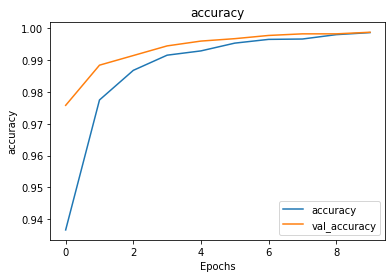

In [ ]:
plot_graphs(history, "accuracy")

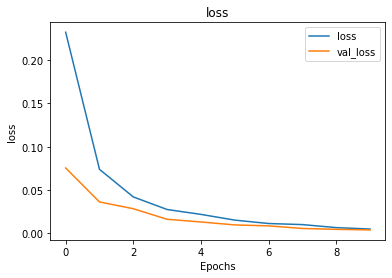

In [ ]:
plot_graphs(history, "loss")

## Predict

In [ ]:
pred = model.predict(val_dataset)#,batch_size=BATCH_SIZE)

In [ ]:
pred_tweet = np.argmax(pred, axis=-1)

In [ ]:
pred_tweet

array([4, 4, 4, ..., 4, 4, 0])

In [ ]:

# ubah Val label ke 1d 

val_label

array([[0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       ...,
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0]], dtype=int32)

In [ ]:
val_label1d = pd.DataFrame(val_label).stack()

In [ ]:

#ubah dari ohe ke 1D

val_label1d = pd.Series(pd.Categorical(val_label1d[val_label1d!=0].index.get_level_values(1)))

In [ ]:
val_label1d

0       4
1       4
2       4
3       4
4       4
       ..
3960    4
3961    4
3962    4
3963    4
3964    0
Length: 3965, dtype: category
Categories (5, int64): [0, 1, 2, 3, 4]

In [ ]:
# ubah dari numeric ke category target, mengunakan label encoder inverse transform

pred_label = lc.inverse_transform(pred_tweet)
val_label1d = lc.inverse_transform(val_label1d)

In [ ]:

#liat metrics classification 

classification_report(val_label1d, pred_label)

'                              precision    recall  f1-score   support\n\nHarmful_Traditional_practice       1.00      0.95      0.97        19\n           Physical_violence       1.00      1.00      1.00       594\n           economic_violence       0.95      0.95      0.95        22\n          emotional_violence       1.00      0.98      0.99        65\n             sexual_violence       1.00      1.00      1.00      3265\n\n                    accuracy                           1.00      3965\n                   macro avg       0.99      0.98      0.98      3965\n                weighted avg       1.00      1.00      1.00      3965\n'

In [ ]:
cf = confusion_matrix(val_label1d, pred_label)

Text(0.5, 51.0, 'Prediction values')

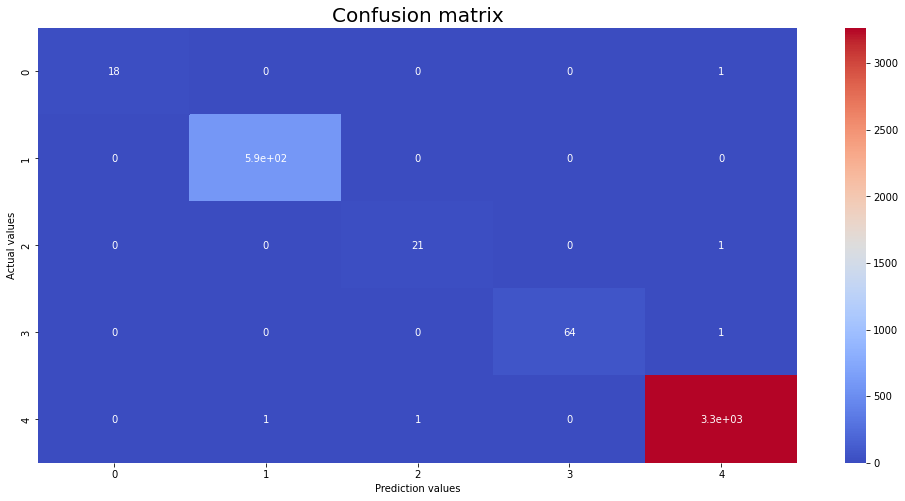

In [ ]:
#plt.subplots(1, 1,
plt.figure(figsize=(17, 8)) 

sns.heatmap(cf, annot=True, cmap="coolwarm")
plt.title("Confusion matrix", size=20)
plt.ylabel("Actual values")
plt.xlabel("Prediction values")

In [ ]:
# make a submission 
sub

,Tweet_ID,type
0,ID_0095QL4S,NaN
1,ID_00DREW5O,NaN
2,ID_00E9F5X9,NaN
3,ID_00G9OSKZ,NaN
4,ID_00HU96U6,NaN
...,...,...
15576,ID_ZZR1D21T,NaN
15577,ID_ZZSQF54Y,NaN
15578,ID_ZZTN5126,NaN
15579,ID_ZZWS0XZZ,NaN


In [ ]:
y_true = model.predict([X_test_ids, X_test_attention],batch_size=BATCH_SIZE)

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond/Identity_8:0' shape=(None, 128) dtype=int32>]


In [ ]:

# check probability 
y_true[1]

array([9.9596584e-01, 2.4208825e-03, 9.4657044e-05, 1.8916102e-04,
       1.3295467e-03], dtype=float32)

In [ ]:
y_true = np.argmax(y_true, axis=-1)

In [ ]:
y_true

array([3, 0, 0, ..., 4, 4, 4])

In [ ]:

# ubah nilai numeric ke category label 

sub["type"] = lc.inverse_transform(y_true)

In [ ]:
sub.type.value_counts()

sexual_violence                 12072
Harmful_Traditional_practice     2680
emotional_violence                630
Physical_violence                 140
economic_violence                  59
Name: type, dtype: int64

In [ ]:
sub

,Tweet_ID,type
0,ID_0095QL4S,emotional_violence
1,ID_00DREW5O,Harmful_Traditional_practice
2,ID_00E9F5X9,Harmful_Traditional_practice
3,ID_00G9OSKZ,sexual_violence
4,ID_00HU96U6,sexual_violence
...,...,...
15576,ID_ZZR1D21T,Harmful_Traditional_practice
15577,ID_ZZSQF54Y,Harmful_Traditional_practice
15578,ID_ZZTN5126,sexual_violence
15579,ID_ZZWS0XZZ,sexual_violence


In [ ]:
sub.to_csv("submission.csv", index=False)